In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns, warnings

%matplotlib inline
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family='NanumGothic')
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

plt.style.use('ggplot')
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

warnings.filterwarnings(action='ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [2]:
df_raw = pd.read_csv('cl3.csv')

#### 1, 2, 3월 데이터만 추출

In [33]:
df = df_raw[(df_raw['REG_YYMM'] == 202001) | (df_raw['REG_YYMM'] == 202002) | (df_raw['REG_YYMM'] == 202003)]
df.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV,year,month
425,202001,제주,여행사업,20s,1,1,20,302800,20,1,2020,1
426,202001,제주,여행사업,20s,2,1,44,613300,45,1,2020,1
427,202001,제주,여행사업,30s,1,2,41,1344600,44,1,2020,1
428,202001,제주,여행사업,30s,2,2,27,551880,28,1,2020,1
429,202001,제주,여행사업,40s,1,2,3,2405000,6,1,2020,1


In [34]:
df = df_raw
df.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV,year,month
0,201901,제주,여행사업,20s,1,1,13,304000,14,0,2019,1
1,201901,제주,여행사업,20s,2,1,98,2014200,102,0,2019,1
2,201901,제주,여행사업,30s,1,2,66,3241566,67,0,2019,1
3,201901,제주,여행사업,30s,2,2,52,3089420,54,0,2019,1
4,201901,제주,여행사업,40s,1,3,72,8238050,83,0,2019,1


# Data Preprocessing

In [35]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [36]:
df['year'] = df['REG_YYMM'].apply(lambda x: grap_year(x))
df['month'] = df['REG_YYMM'].apply(lambda x: grap_month(x))
df = df.drop(['REG_YYMM'], axis=1)

In [37]:
def make_season(data):
    if data in [12, 1, 2]:
        return 'Winter'
    elif data in [3, 4, 5]:
        return 'Spring'
    elif data in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [38]:
df['Season'] = df['month'].apply(lambda x: make_season(x))

In [39]:
df.head()

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV,year,month,Season
0,제주,여행사업,20s,1,1,13,304000,14,0,2019,1,Winter
1,제주,여행사업,20s,2,1,98,2014200,102,0,2019,1,Winter
2,제주,여행사업,30s,1,2,66,3241566,67,0,2019,1,Winter
3,제주,여행사업,30s,2,2,52,3089420,54,0,2019,1,Winter
4,제주,여행사업,40s,1,3,72,8238050,83,0,2019,1,Winter


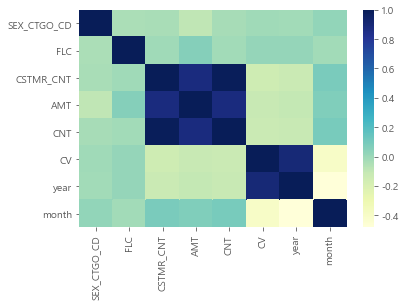

In [40]:
sns.heatmap(df.corr(),cmap='YlGnBu',fmt='.1g')

# Label Encoding

In [41]:
# 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   CARD_SIDO_NM  510 non-null    int32
 1   STD_CLSS_NM   510 non-null    int32
 2   AGE           510 non-null    int32
 3   SEX_CTGO_CD   510 non-null    int64
 4   FLC           510 non-null    int64
 5   CSTMR_CNT     510 non-null    int64
 6   AMT           510 non-null    int64
 7   CNT           510 non-null    int64
 8   CV            510 non-null    int64
 9   year          510 non-null    int64
 10  month         510 non-null    int64
 11  Season        510 non-null    int32
dtypes: int32(4), int64(8)
memory usage: 40.0 KB


In [43]:
df.STD_CLSS_NM.unique()

array([0, 1])

In [44]:
df['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

# Preprocessing

In [45]:
# 변수명 지정
X_cols = list(df.columns)
X_cols.remove('AMT')

In [46]:
X = df.drop(['AMT'], axis=1)
y = np.log1p(df['AMT'])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [48]:
X_train

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,CNT,CV,year,month,Season
242,0,1,3,2,4,41,81,0,2019,7,2
0,0,0,1,1,1,13,14,0,2019,1,3
376,0,1,1,2,2,11,17,0,2019,11,0
185,0,0,4,1,4,86,103,0,2019,6,2
255,0,0,3,1,2,6,6,0,2019,8,2
...,...,...,...,...,...,...,...,...,...,...,...
206,0,1,4,1,3,3,5,0,2019,6,2
371,0,0,5,1,5,12,13,0,2019,11,0
55,0,1,2,2,3,3,4,0,2019,2,3
295,0,0,3,1,2,3,3,0,2019,9,0


# Light Gradient Boosting Machine

In [49]:
import lightgbm as lgb

In [50]:
train_ds = lgb.Dataset(X_train, label=y_train)
val_ds = lgb.Dataset(X_test, label=y_test)

In [51]:
params = {
            'learning_rate' : 0.1,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1        }

In [52]:
model = lgb.train(params,
                  train_ds,
                  5000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                 )

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.571702
Early stopping, best iteration is:
[51]	valid_0's rmse: 0.569028


# Template

In [53]:
X.columns

Index(['CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT',
       'CNT', 'CV', 'year', 'month', 'Season'],
      dtype='object')

In [54]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df['STD_CLSS_NM'].unique()
AGEs          = df['AGE'].unique()
SEX_CTGO_CDs  = df['SEX_CTGO_CD'].unique()
FLCs          = df['FLC'].unique()
Seasons = df['Season'].unique()
years         = [2020]
months        = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for AGE in AGEs:
            for SEX_CTGO_CD in SEX_CTGO_CDs:
                for FLC in FLCs:
                    for year in years:
                        for month in months:
                            for Season in Seasons:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, AGE, SEX_CTGO_CD, FLC, year, month, Season])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=['CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month', 'Season'])

In [55]:
temp

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,year,month,Season
0,0,0,1,1,1,2020,4,3
1,0,0,1,1,1,2020,4,1
2,0,0,1,1,1,2020,4,2
3,0,0,1,1,1,2020,4,0
4,0,0,1,1,1,2020,7,3
...,...,...,...,...,...,...,...,...
1115,0,1,6,2,5,2020,4,0
1116,0,1,6,2,5,2020,7,3
1117,0,1,6,2,5,2020,7,1
1118,0,1,6,2,5,2020,7,2


In [56]:
df2 = df[(df['year']==2020) & (df['month']==3)]
df3 = df[(df['year']==2020) & (df['month']==3)]
df4 = pd.concat([df2, df3], axis=0)

In [57]:
df4.drop(['AMT', 'year', 'month', 'Season'], axis=1, inplace=True)

In [58]:
temp = pd.merge(temp, df4, on=['CARD_SIDO_NM','STD_CLSS_NM','AGE','SEX_CTGO_CD','FLC'])

In [59]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)

In [60]:
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [61]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [62]:
v = pd.merge(temp[temp['REG_YYMM']==202004],df_raw[df_raw['REG_YYMM']==202003].groupby(['STD_CLSS_NM'])[['AMT']].sum().reset_index(), on=['STD_CLSS_NM'])
v = v.drop(['REG_YYMM', 'CARD_SIDO_NM'], axis=1)
v = v.rename(columns={'AMT_x' : '4월', 'AMT_y' : '3월'})
v['3월 대비 증감률'] = (v['4월'] - v['3월']) / v['3월'] * 100
v

,STD_CLSS_NM,4월,3월,3월 대비 증감률
0,여행사업,73422286.0,3933600,1766.541743
1,휴양콘도 운영업,261431866.0,38719765,575.189702


In [63]:
temp.to_csv('./template3.csv',index=False, encoding='utf-8-sig')